라이브러리

In [136]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 모델명(= 파일명) 설정
model_name = 'doRegressor_tank1'

데이터셋 설정

In [137]:
#자포니카 훈련 데이터
japonica_training_food_supply_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_training_food_supply_tb.csv")
japonica_training_sensor_val_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_training_sensor_val_tb.csv")

#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_validation_food_supply_tb.csv")
japonica_validation_sensor_val_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_validation_sensor_val_tb.csv")

#자포니카 사료 공급 데이터 null제거
japonica_training_food_supply_tb = japonica_training_food_supply_tb[japonica_training_food_supply_tb['feed_quantity'].notnull()]
japonica_validation_food_supply_tb = japonica_validation_food_supply_tb[japonica_validation_food_supply_tb['feed_quantity'].notnull()]



In [138]:
japonica_training_food_supply_tb

,farm_id,tank_id,feed_dt,feed_code,feed_quantity,water_quantity,add_code,add_quantity,add_code2,add_quantity2,add_code3,add_quantity3,add_code4,add_quantity4,add_code5,add_quantity5,reg_dt
0,1,1,202107210430,s2-g,6.2,9.3,c3-g,18.6,c1-g,12.4,c2-g,6.2,NaN,NaN,NaN,NaN,2021-09-16 18:55:19
1,1,1,202107211630,s2-g,6.2,9.3,c3-g,18.6,c1-g,12.4,c2-g,6.2,NaN,NaN,NaN,NaN,2021-09-16 18:55:19
2,1,1,202107220430,s2-g,6.2,9.3,c3-g,18.6,c1-g,12.4,c2-g,6.2,NaN,NaN,NaN,NaN,2021-09-16 18:55:19
3,1,1,202107221630,s2-g,6.2,9.3,c3-g,18.6,c1-g,12.4,c2-g,6.2,NaN,NaN,NaN,NaN,2021-09-16 18:55:19
4,1,1,202107230430,s2-g,6.2,9.3,c3-g,18.6,c1-g,12.4,c2-g,6.2,NaN,NaN,NaN,NaN,2021-09-16 18:55:19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,1,5,202109071630,s2-g,15.0,19.5,c4-g,105.0,c5-g,30.0,NaN,NaN,NaN,NaN,NaN,NaN,2021-09-16 18:55:19
514,1,5,202109080430,s2-g,15.0,19.5,c4-g,105.0,c5-g,30.0,NaN,NaN,NaN,NaN,NaN,NaN,2021-09-16 18:55:19
517,1,5,202109091630,s2-g,1.0,1.3,c4-g,7.0,c5-g,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2021-09-16 18:55:19
518,1,5,202109100430,s2-g,2.0,2.6,c4-g,14.0,c5-g,4.0,NaN,NaN,NaN,NaN,NaN,NaN,2021-09-16 18:55:19


In [139]:
# 자포니카 검증 데이터의 한 개 탱크
tank = 1
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[japonica_training_sensor_val_tb['tank_id']==tank]
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[japonica_training_sensor_val_tb['tank_id']==tank]

In [140]:
#자포니카 훈련 데이터 시계열 변환
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].apply(str)
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_training_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_training_sensor_val_tb['mea_dt'], format='mixed', errors='raise')

In [141]:
# 시계열 데이터의 개수 확인
training_counts = japonica_training_sensor_val_tb.groupby(japonica_training_sensor_val_tb['mea_dt'].dt.date).size()
#validation_counts = japonica_validation_features.groupby(japonica_validation_features.index.mea_dt).size()

# 개수가 1440이 아닌 시계열 삭제
to_delete = training_counts[training_counts != 1440].index
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[~japonica_training_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]

#to_delete = validation_counts[validation_counts != 1440].index
#japonica_validation_data = japonica_validation_features[~japonica_validation_features.index.floor('D').isin(to_delete)]

In [142]:
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')


In [143]:
japonica_training_sensor_val_tb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 187200 entries, 1485 to 1107993
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  187200 non-null  int64  
 1   farm_id     187200 non-null  int64  
 2   tank_id     187200 non-null  int64  
 3   mea_dt      187200 non-null  object 
 4   do_mg       187200 non-null  float64
 5   do_temp     187200 non-null  float64
 6   ph          187200 non-null  float64
 7   orp         187200 non-null  float64
 8   co2_mg      187200 non-null  float64
 9   air_oxy     187200 non-null  float64
 10  light_ma    187200 non-null  float64
dtypes: float64(7), int64(3), object(1)
memory usage: 17.1+ MB


In [144]:
#자포니카 훈련 데이터 시계열 변환
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_training_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_training_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].apply(str)
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

#자포니카 검증 데이터 시계열 변환
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

In [145]:
# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_training = pd.merge(left = japonica_training_sensor_val_tb, right = japonica_training_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])


In [146]:
japonica_training

,Unnamed: 0,farm_id,tank_id,mea_dt,do_mg,do_temp,ph,orp,co2_mg,air_oxy,...,add_quantity,add_code2,add_quantity2,add_code3,add_quantity3,add_code4,add_quantity4,add_code5,add_quantity5,reg_dt
0,1485,1,1,2021-07-16 00:00,8.3,30.4,5.63,156.0,15.4,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1490,1,1,2021-07-16 00:01,8.4,30.4,5.63,155.7,15.4,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1495,1,1,2021-07-16 00:02,8.4,30.4,5.63,155.8,15.4,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1500,1,1,2021-07-16 00:03,8.4,30.4,5.63,156.0,15.4,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1505,1,1,2021-07-16 00:04,8.4,30.4,5.62,156.3,15.4,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187195,1107973,1,1,2022-01-05 23:55,12.0,28.7,5.19,222.8,31.2,11.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187196,1107978,1,1,2022-01-05 23:56,12.0,28.7,5.19,222.8,31.1,11.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187197,1107983,1,1,2022-01-05 23:57,12.0,28.7,5.18,222.9,31.1,11.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187198,1107988,1,1,2022-01-05 23:58,12.1,28.7,5.18,222.8,31.1,11.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [147]:

#자포니카 훈련 및 검증 데이터 시계열 변환
japonica_training['mea_dt'] = pd.to_datetime(japonica_training['mea_dt'], format='mixed', errors='raise')

In [148]:
japonica_training

,Unnamed: 0,farm_id,tank_id,mea_dt,do_mg,do_temp,ph,orp,co2_mg,air_oxy,...,add_quantity,add_code2,add_quantity2,add_code3,add_quantity3,add_code4,add_quantity4,add_code5,add_quantity5,reg_dt
0,1485,1,1,2021-07-16 00:00:00,8.3,30.4,5.63,156.0,15.4,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1490,1,1,2021-07-16 00:01:00,8.4,30.4,5.63,155.7,15.4,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1495,1,1,2021-07-16 00:02:00,8.4,30.4,5.63,155.8,15.4,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1500,1,1,2021-07-16 00:03:00,8.4,30.4,5.63,156.0,15.4,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1505,1,1,2021-07-16 00:04:00,8.4,30.4,5.62,156.3,15.4,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187195,1107973,1,1,2022-01-05 23:55:00,12.0,28.7,5.19,222.8,31.2,11.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187196,1107978,1,1,2022-01-05 23:56:00,12.0,28.7,5.19,222.8,31.1,11.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187197,1107983,1,1,2022-01-05 23:57:00,12.0,28.7,5.18,222.9,31.1,11.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187198,1107988,1,1,2022-01-05 23:58:00,12.1,28.7,5.18,222.8,31.1,11.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [149]:
# 사용할 features 선택
feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_training_features = japonica_training[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_training_features = japonica_training_features.fillna(0)

In [150]:
japonica_training_features

,tank_id,mea_dt,do_mg,do_temp,ph,orp,co2_mg,air_oxy,light_ma,feed_quantity,water_quantity
0,1,2021-07-16 00:00:00,8.3,30.4,5.63,156.0,15.4,0.0,3.9,0.0,0.0
1,1,2021-07-16 00:01:00,8.4,30.4,5.63,155.7,15.4,0.0,3.9,0.0,0.0
2,1,2021-07-16 00:02:00,8.4,30.4,5.63,155.8,15.4,0.0,4.0,0.0,0.0
3,1,2021-07-16 00:03:00,8.4,30.4,5.63,156.0,15.4,0.0,4.0,0.0,0.0
4,1,2021-07-16 00:04:00,8.4,30.4,5.62,156.3,15.4,0.0,3.9,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
187195,1,2022-01-05 23:55:00,12.0,28.7,5.19,222.8,31.2,11.4,4.0,0.0,0.0
187196,1,2022-01-05 23:56:00,12.0,28.7,5.19,222.8,31.1,11.2,4.0,0.0,0.0
187197,1,2022-01-05 23:57:00,12.0,28.7,5.18,222.9,31.1,11.1,4.0,0.0,0.0
187198,1,2022-01-05 23:58:00,12.1,28.7,5.18,222.8,31.1,11.4,4.1,0.0,0.0


In [151]:
japonica_training_data = japonica_training_features

In [152]:
# 날짜 데이터를 인덱스로 전환
japonica_training_data.set_index('mea_dt', inplace=True)

In [153]:


# 인덱스 순으로 데이터를 정렬
japonica_training_data = japonica_training_data.sort_index()
# 8월 1달간 데이터만 추출
japonica_training_data = japonica_training_data.loc['2021-07-21 00:00':'2021-09-10 23:59']

In [154]:
japonica_training_features_X = japonica_training_data[['do_mg','feed_quantity']]

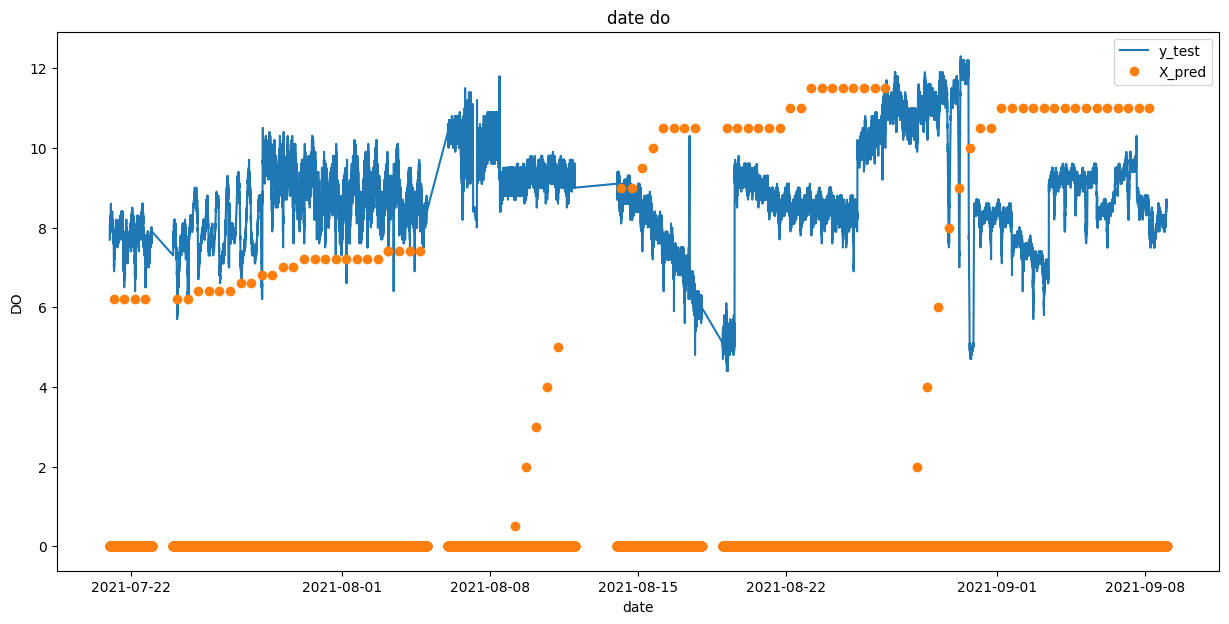

In [155]:
plt.figure(figsize=(15, 7))
plt.plot(japonica_training_data.index, japonica_training_data[['do_mg']], label='actual')  # x축에 년월일, y축에 값
plt.plot(japonica_training_data.index, japonica_training_data[['feed_quantity']], marker='o', linestyle='None', label='actual')  # x축에 년월일, y축에 값
plt.xlabel('date')
plt.ylabel('DO')
plt.title('date do')
plt.legend(['y_test','X_pred'])
plt.show()